In [15]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [16]:
# Load Data and Preprocess
def load_data(filepath):
    """Load and preprocess the bank marketing dataset."""
    
    # 1. Load CSV (semicolon separator)
    df = pd.read_csv(filepath, sep=';')
    
    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'poutcome', 'y']
    
    # 2. Apply Label Encoding
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    
    # Select features
    features = ['age', 'balance', 'campaign', 'previous', 
                'job', 'education', 'housing', 'loan', 'default']
    X = df[features]
    
    # 3. Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, df

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Plot explained variance
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')

    # 2D PCA scatter
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=15)
    plt.title("Data Distribution in PCA Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()
    
    return X_pca

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method) 
def find_optimal_clusters(x, max_clusters=10):
    from sklearn.cluster import KMeans

    inertias = []
    K = range(1, max_clusters + 1)

    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(x)
        inertias.append(km.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertias, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow Method to Find Optimal k")
    plt.grid(True)
    plt.show()

# Perform KMeans Clustering 
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    from sklearn.cluster import KMeans

    if n_clusters is None:
        raise ValueError("Please specify n_clusters based on the elbow method.")

    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(x)

    return labels, model.cluster_centers_

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering 
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    from sklearn.cluster import AgglomerativeClustering

    if n_clusters is None:
        raise ValueError("Please specify n_clusters.")

    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(x)

    return labels

from scipy.cluster.hierarchy import linkage, dendrogram

def get_linkages(x):
    return linkage(x, method='ward')

def plot_dendrogram(linked):
    plt.figure(figsize=(12, 5))
    dendrogram(linked)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Samples")
    plt.ylabel("Distance")
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [17]:
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                        'loan', 'contact', 'month', 'poutcome', 'y']

    # 2. Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # 3. Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 
                'job', 'education', 'housing', 'loan', 'default']
    X = df[features]

    # 4. Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


In [18]:
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Randomly select `n_clusters` points from X as centroids."""
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid."""
        # Distance from each point to each centroid
        distances = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
        # Index of closest centroid
        return np.argmin(distances, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as mean of assigned points."""
        new_centroids = []
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) == 0:
                # If no points assigned, keep old centroid
                new_centroids.append(self.centroids[k])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        return np.array(new_centroids)

    def fit(self, X):
        """Run K-means until convergence."""
        # 1. Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for _ in range(self.max_iters):
            # 2. Assign each point to closest centroid
            labels = self._assign_clusters(X)

            # 3. Compute new centroids
            new_centroids = self._update_centroids(X, labels)

            # 4. Stop if centroids did not change
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

        # Save results
        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids."""
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

Explained Variance Ratio: [0.14878447 0.13240902]
Cumulative Variance: [0.14878447 0.28119349]


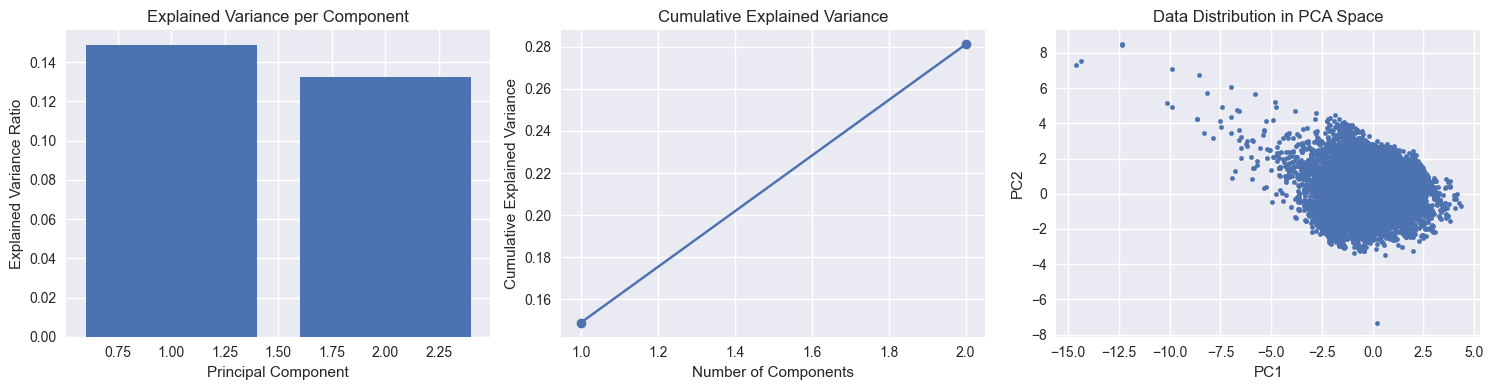

Shape after PCA: (45211, 2)


In [19]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction."""
    
    # 1. Initialize and fit PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # 2. Create visualization
    plt.figure(figsize=(15, 4))

    # ---- Explained Variance Ratio ----
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance per Component")

    # ---- Cumulative Explained Variance ----
    plt.subplot(1, 3, 2)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Cumulative Explained Variance")
    plt.grid(True)

    # ---- 2D PCA Scatter Plot ----
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Data Distribution in PCA Space")

    plt.tight_layout()
    plt.show()

    return X_pca

pca = PCA(n_components=2)
pca.fit(X_scaled)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

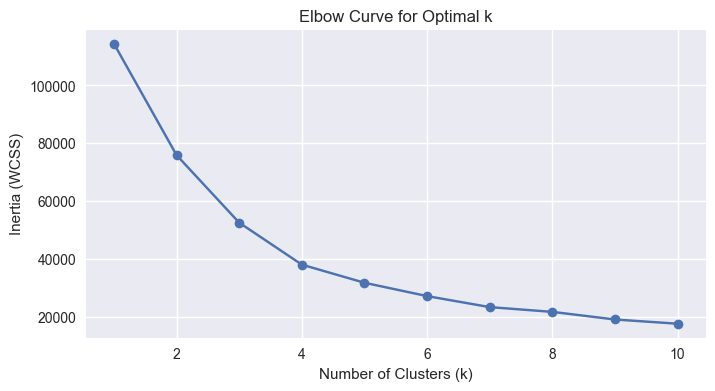

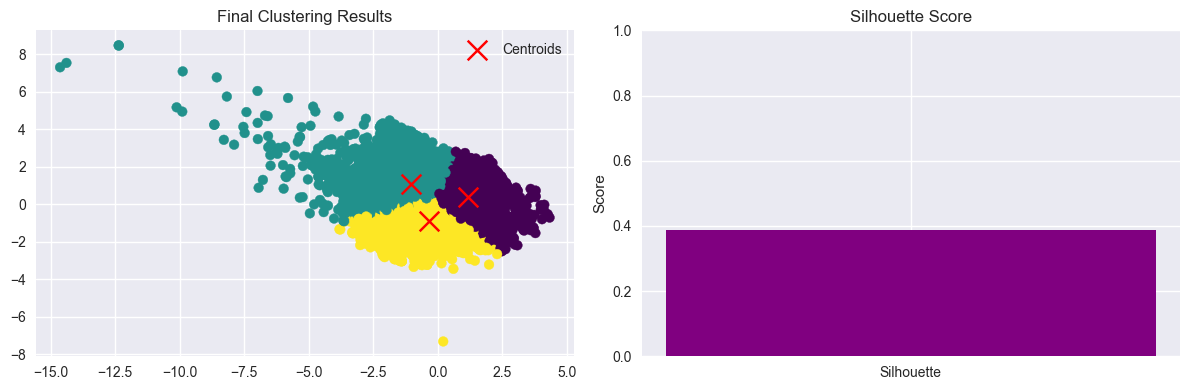

In [20]:
def calculate_inertia(X, labels, centroids):
    inertia = 0
    for k in range(len(centroids)):
        cluster_points = X[labels == k]
        inertia += np.sum((cluster_points - centroids[k])**2)
    return inertia

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters."""
    
    from sklearn.cluster import KMeans

    inertias = []
    K = range(1, max_k + 1)
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertias, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (WCSS)")
    plt.title("Elbow Curve for Optimal k")
    plt.grid(True)
    plt.show()
    
    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

plt.figure(figsize=(12, 4))

# ---- Plot clusters ----
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# ---- Plot evaluation metrics ----
plt.subplot(1, 2, 2)
sil = silhouette_score(X_pca, kmeans.labels)
plt.bar(["Silhouette"], [sil], color='purple')
plt.ylim(0, 1)
plt.title("Silhouette Score")
plt.ylabel("Score")

plt.tight_layout()
plt.show()

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

In [21]:
from sklearn.cluster import KMeans

class BisectingKMeans:
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until n_clusters is reached."""
        
        # Start: all points in cluster 0
        labels = np.zeros(len(X), dtype=int)
        current_cluster_id = 1   # Next available cluster label

        while len(np.unique(labels)) < self.n_clusters:

            # 1. Select the largest cluster
            largest_cluster = np.argmax(np.bincount(labels))
            idx = np.where(labels == largest_cluster)[0]
            subset = X[idx]

            # 2. Perform binary KMeans on this subset
            km = KMeans(n_clusters=2, random_state=self.random_state)
            km.fit(subset)
            split_labels = km.labels_

            # 3. Assign new labels
            left_child = largest_cluster
            right_child = current_cluster_id  # new cluster id

            labels[idx[split_labels == 0]] = left_child
            labels[idx[split_labels == 1]] = right_child

            # 4. Store split structure and centroids
            self.split_tree[largest_cluster] = (left_child, right_child)
            self.centers_[left_child] = km.cluster_centers_[0]
            self.centers_[right_child] = km.cluster_centers_[1]

            # 5. Prepare for next iteration
            current_cluster_id += 1

        self.labels_ = labels
        return labels

In [22]:
bisect = BisectingKMeans(n_clusters=4)
bisect_labels = bisect.fit_predict(X_pca)

print("Cluster Labels:", bisect_labels)
print("Cluster Centers:", bisect.centers_)
print("Split Tree:", bisect.split_tree)

from sklearn.metrics import silhouette_score
sil_bisect = silhouette_score(X_pca, bisect_labels)
print("Silhouette Score (Bisecting KMeans):", sil_bisect)

# Cluster sizes
unique, counts = np.unique(bisect_labels, return_counts=True)
print("Cluster Sizes:", dict(zip(unique, counts)))

Cluster Labels: [3 0 2 ... 3 3 1]
Cluster Centers: {np.int64(0): array([ 0.49855208, -0.92894064]), 1: array([-0.97745328, -0.67392201]), 2: array([1.0984422 , 0.66711512]), 3: array([-1.10825956,  1.31719574])}
Split Tree: {np.int64(0): (np.int64(0), 2), np.int64(1): (np.int64(1), 3)}
Silhouette Score (Bisecting KMeans): 0.33606596230677405
Cluster Sizes: {np.int64(0): np.int64(11350), np.int64(1): np.int64(12618), np.int64(2): np.int64(13705), np.int64(3): np.int64(7538)}


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!